<a href="https://www.kaggle.com/code/aissaasasd/sentiment-analysis-using-bert-transfer-learning?scriptVersionId=150065344" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**1- load libraries**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
import tensorflow_hub as hub
import matplotlib.pyplot as plt 

import tensorflow_text as text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**2-load data**

In [2]:
data = pd.read_csv("/kaggle/input/threads-an-instagram-app-reviews/threads_reviews.csv", parse_dates=["review_date"])

In [3]:
data

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43
...,...,...,...,...
32905,App Store,This killed my dog. Mark zuckerburg strangled ...,1,2023-07-06 01:23:55
32906,App Store,Add Search and hashtag like Twitter !,1,2023-07-19 08:01:06
32907,App Store,bad twister,1,2023-07-17 06:39:13
32908,App Store,Yet another trash from Meta.,1,2023-07-07 17:47:16


**3-converting labels into numeric**

In [4]:
convert = {1:-1,2:-1,3:0,4:1,5:1}
data["rating"] = data["rating"].replace(convert)

**4-visualize rating categories**

<Axes: xlabel='rating', ylabel='count'>

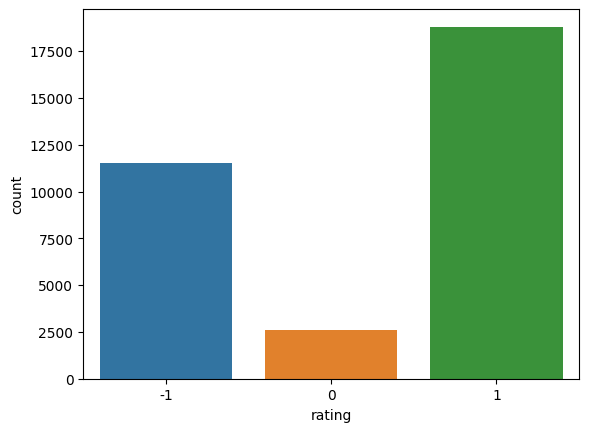

In [5]:
import seaborn as sns
sns.countplot(x='rating', data=data)


**5-prepare and split data for training**

In [6]:
X = data["review_description"].str.lower()
y = pd.get_dummies(data["rating"])

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

**6-load bert tokenizer and the model**

In [9]:
bert = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2",trainable=False)
tokenize = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

**7-design and train the model**

In [10]:
inp = tf.keras.layers.Input(shape=(),dtype=tf.string)
tok= tokenize(inp)
bert_ = bert(tok)
drop_out = tf.keras.layers.Dropout(0.1)(bert_["pooled_output"])
flatten= tf.keras.layers.Dense(300)(drop_out)
drop_out = tf.keras.layers.Dense(100
                        ,kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3),
    bias_regularizer=tf.keras.regularizers.L2(1e-3),
    activity_regularizer=tf.keras.regularizers.L2(1e-4))(flatten)
drop_out = tf.keras.layers.Dropout(0.4)(drop_out)
drop_out = tf.keras.layers.Dense(300)(drop_out)
drop_out = tf.keras.layers.Dropout(0.4)(drop_out)
drop_out = tf.keras.layers.Dense(100)(drop_out)
drop_out = tf.keras.layers.Dropout(0.4)(drop_out)

output = tf.keras.layers.Dense(3,activation="softmax")(drop_out)

model = tf.keras.models.Model(inp,output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [11]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

In [12]:
model.fit(X_train,y_train,epochs=3,validation_data=(X_test,y_test),batch_size=16)

Epoch 1/3
1852/1852 [==============================] - 119s 58ms/step - loss: 1.1703 - accuracy: 0.6704 - val_loss: 0.9097 - val_accuracy: 0.7645
Epoch 2/3
1852/1852 [==============================] - 109s 59ms/step - loss: 1.0240 - accuracy: 0.7174 - val_loss: 0.8767 - val_accuracy: 0.7736
Epoch 3/3
1852/1852 [==============================] - 109s 59ms/step - loss: 0.9662 - accuracy: 0.7349 - val_loss: 0.8446 - val_accuracy: 0.7736


**8-save the model**

In [13]:
model.save("sentiment.h5")

**9-make prediction**

In [14]:
model.predict(["this app is not good and it very boring "])

1/1 [==============================] - 1s 658ms/step


array([[0.61083645, 0.08240031, 0.30676323]], dtype=float32)